In [2]:
import numpy as np
from matplotlib.path import Path
from matplotlib import pyplot as plt
import pickle

import sys
sys.path.insert(0,'./src/')

from utils import *
from pipe import *
from pipe_system import PipeSystem
from abstract_pipe import *
from pipe_system.let_index import LetIndex
from multiply_connected_pipe_bhfmm import MultiplyConnectedPipeFromPipeSystem
from fmm2dpy import cfmm2d

In [3]:
with open('./exp1/dev_Pipes.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

In [4]:
bdr_pipe = BoundaryPipe([BoundaryLet(-5,0,0,1,-1),BoundaryLet(31,0,np.pi,1,1)])
real_pipes = [RealPipe(p,shift_x=shift[0],shift_y=shift[1]) for p,shift in zip(pipes,shifts)]
ps = PipeSystem(real_pipes,bdr_pipe)
pipe = MultiplyConnectedPipeFromPipeSystem(ps)

In [5]:
xs, ys, interior, u_field, v_field, p_field, o_field = ps.plotting_data()

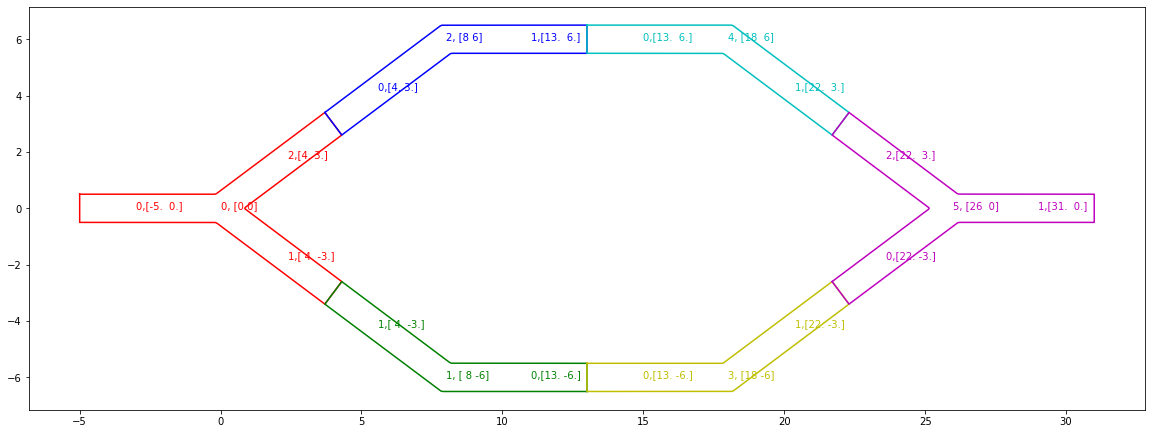

In [6]:
color = ['r','g','b','y','c','m','k']

fig,ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,color):
    ax.plot(*(i.closed_boundary + j).T,c=c)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k},{let.matching_pt + j}',color=c)
    ax.text(*j,f'{a}, {j}',color=c)

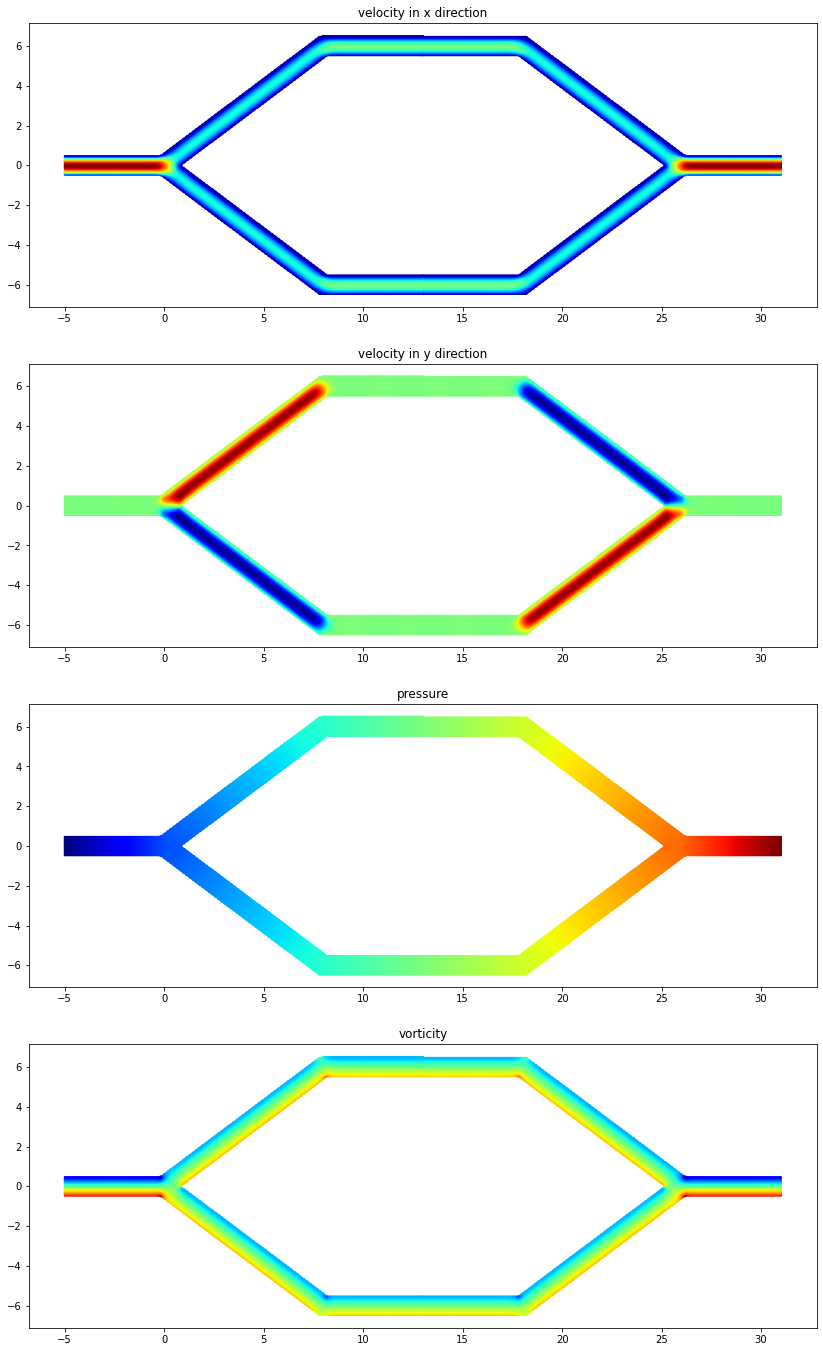

In [7]:
fig,axes = plt.subplots(4,1,figsize=(20,24))

for ax, field, title, in zip(axes, [u_field,v_field,p_field,o_field], ['velocity in x direction','velocity in y direction','pressure','vorticity']):
    ax.set_aspect('equal')
    ax.scatter(xs,ys,c=field,s=1,cmap='jet')
    ax.set_title(title)

In [8]:
pipe.build(tol=1e-5)

In [9]:
pipe.build_plotting_data(xs,ys,interior)

In [10]:
start, end = pipe.indices_of_boundary[1]

In [11]:
np.sum((pipe.omegas[0]*pipe.dt)[start:end])

(-1.626627692985494e-06+5.158391545023733e-07j)

In [12]:
u_global, v_global, p_global, o_global = pipe.fields_with_fluxes(np.array([1]),0,0)

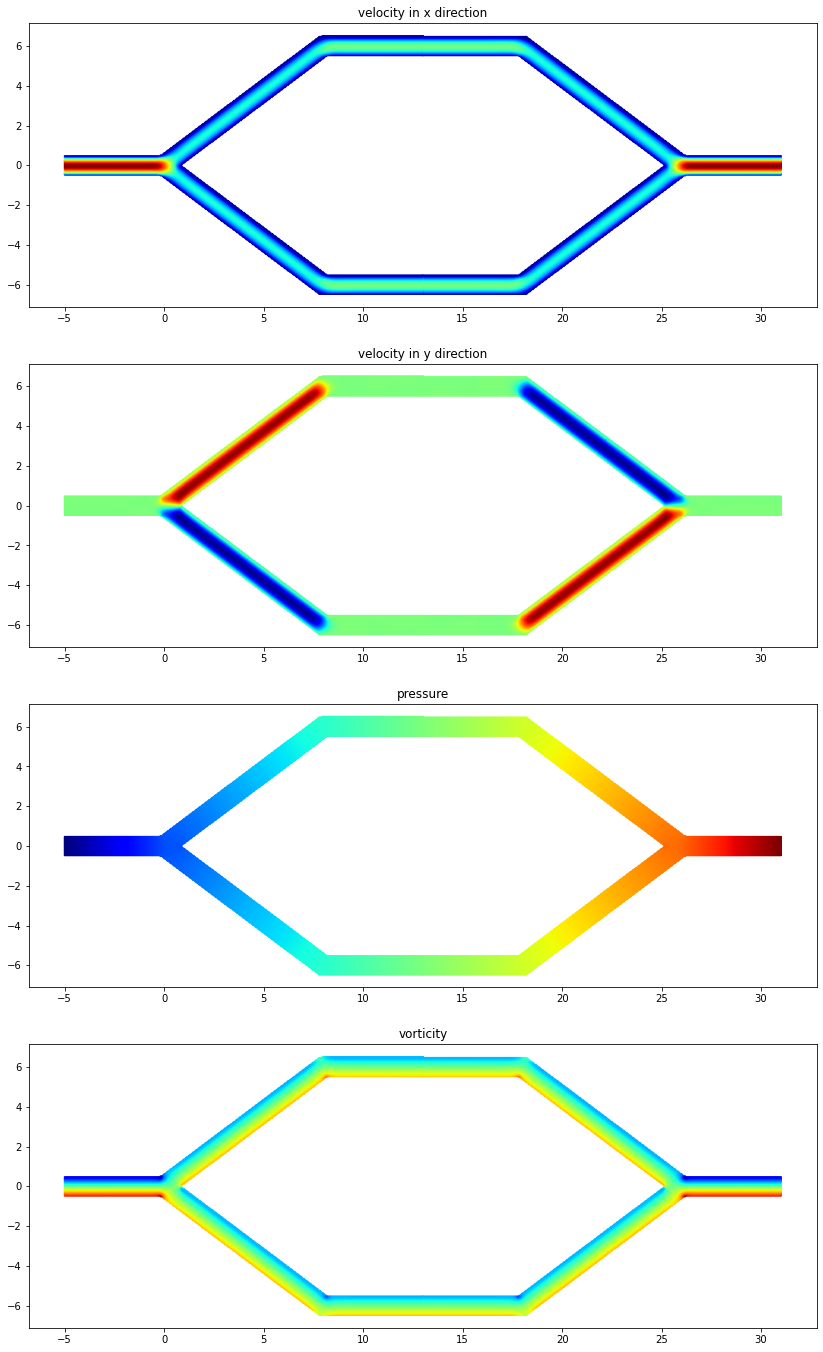

In [13]:
fig,axes = plt.subplots(4,1,figsize=(20,24))

for ax, field, title, in zip(axes, [u_global,v_global,p_global,o_global], ['velocity in x direction','velocity in y direction','pressure','vorticity']):
    ax.set_aspect('equal')
    ax.scatter(xs,ys,c=field,s=1,cmap='jet')
    ax.set_title(title)

In [14]:
m = np.full(xs.shape,True)

for v in ps.vertices:
    l1, l2 = v.l1, v.l2
    if l1.atBdr or l2.atBdr:
        continue
    l = ps.pipes[l1.pipeIndex].lets[l1.letIndex]
    x, y = l.x, l.y
    m = m & ~((np.abs(xs-x) < 2) & (np.abs(ys-y) > 1))
    
m = m&interior

Text(0.5, 0.98, 'comparing the global solver (using fmm with gmres_tol=1e-5) and combination of the local solvers (using direct matrix multiplication with gmres_tol=1e-10)')

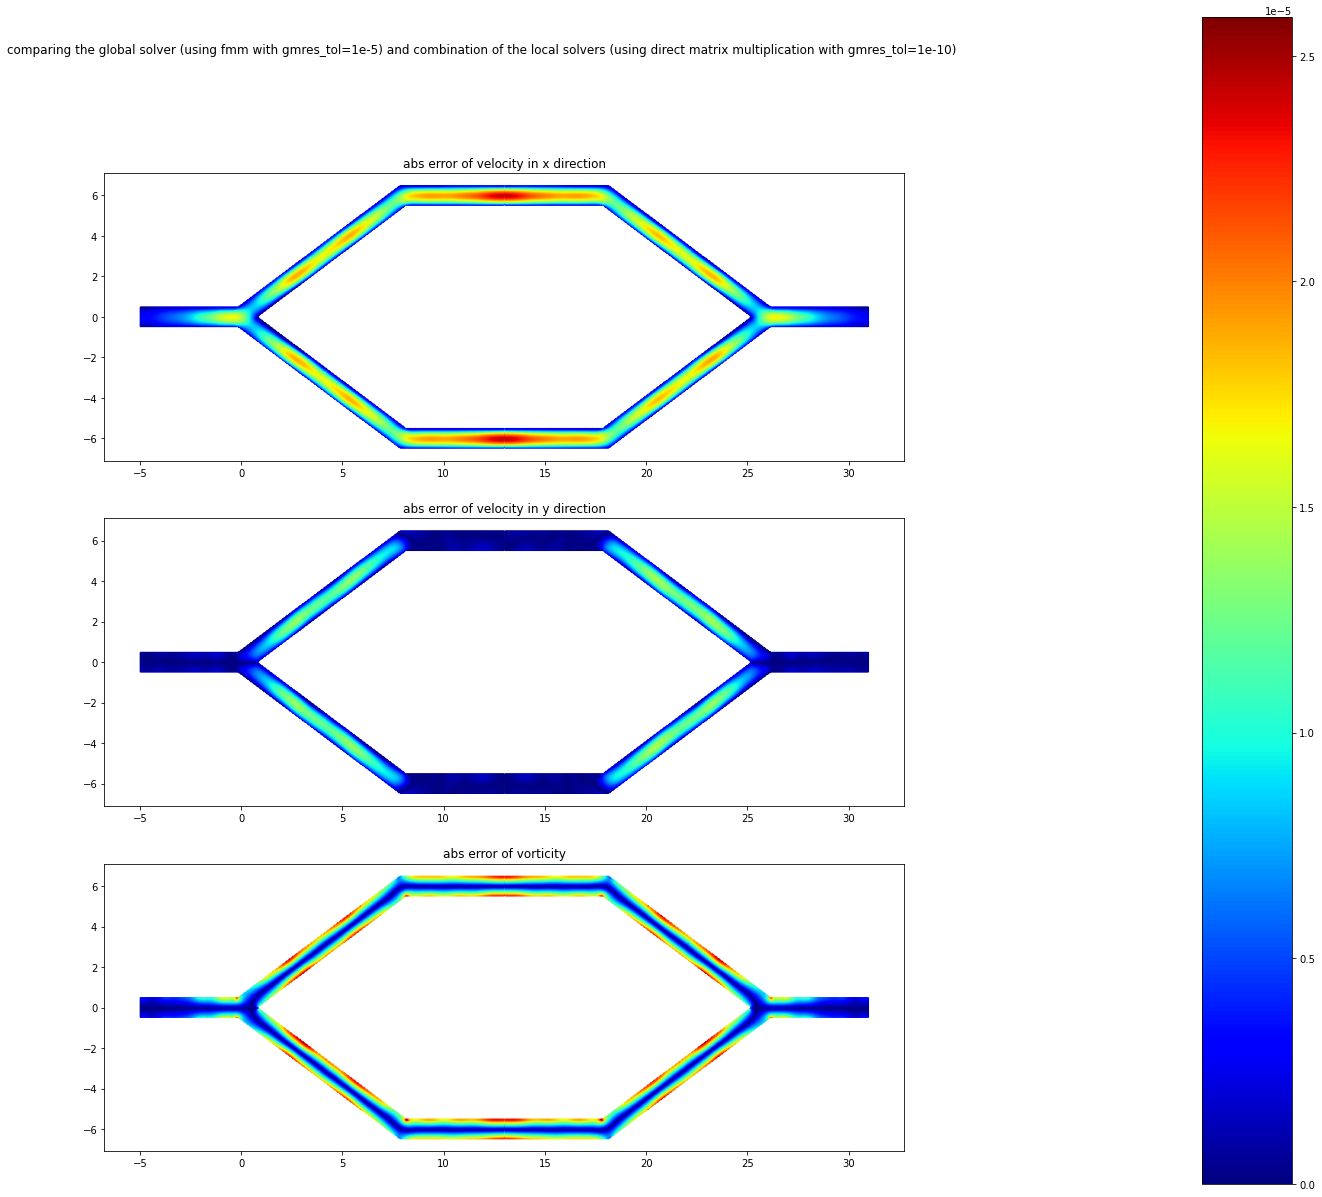

In [15]:
fig,axes = plt.subplots(3,1,figsize=(25,18))

fig.set_facecolor('white')

mask = interior
field1 = [u_field,v_field,o_field]
field2 = [u_global, v_global, o_global]

vmin = 0
vmax = np.max([np.max(np.abs(f1[mask]-f2[mask])) for f1,f2 in zip(field1, field2)])

for ax, f1, f2, title in zip(axes, field1, field2,['velocity in x direction','velocity in y direction','vorticity']):
    ax.set_aspect('equal')
    im = ax.scatter(xs[mask],ys[mask],c=np.abs(f1[mask]-f2[mask]),s=1,cmap='jet',vmin=vmin,vmax=vmax)
    ax.set_title('abs error of '+title)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.9])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('comparing the global solver (using fmm with gmres_tol=1e-5) and combination of the local solvers (using direct matrix multiplication with gmres_tol=1e-10)')
